
# Check Teacher Accuracy — CIFAR-10 (ResNet34)

This notebook loads the **teacher** model (ResNet34 backbone + classifier) for **CIFAR-10** from your repository checkpoints and evaluates its **Top-1 accuracy** on the validation/test split.

It uses:
- `src/data/data_setup.py` for building DataLoaders (no augmentation per your setup).
- `torchvision.models.resnet34` to assemble the model, then loads the **backbone** and **classifier** weights.
- `src/model/ckpts/teachers.json` if available to resolve checkpoint paths automatically; otherwise, it falls back to template paths like `resnet34_{dataset}_backbone.pt` and `resnet34_{dataset}_classifier.pt`.

> If you want to check a different dataset, just change `DATASET` and `NUM_CLASSES` below.


In [24]:

# --- Config ---
DATASET      = "cifar10"   # one of: ["cifar10", "cifar100", "stl10", "tiny_imagenet"]
NUM_CLASSES  = 10          # cifar10=10, cifar100=100, stl10=10, tiny_imagenet=200
BATCH_SIZE   = 256
NUM_WORKERS  = 4
PIN_MEMORY   = True
DOWNLOAD     = False

# Project-relative paths
CKPT_ROOT    = "src/model/ckpts"
TEACHERS_JSON= f"{CKPT_ROOT}/teachers.json"
TEMPLATE_BB  = f"{CKPT_ROOT}/resnet34_{'{dataset}'}_backbone.pt"
TEMPLATE_CLF = f"{CKPT_ROOT}/resnet34_{'{dataset}'}_classifier.pt"
DATA_ROOT    = "dataset"   # same as your config.yaml
DEVICE       = "cuda"      # change to "cpu" if needed


In [25]:

# --- Imports ---
import os, json, torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader
from pathlib import Path

# Use your repository's data loader utility
from src.data.data_setup import loaders

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.5.1+cu121
CUDA available: True


In [26]:

def resolve_teacher_paths(dataset: str):
    """Resolve (backbone_path, classifier_path) from teachers.json or templates."""
    bb_path, clf_path = None, None
    if os.path.exists(TEACHERS_JSON):
        with open(TEACHERS_JSON, "r", encoding="utf-8") as f:
            reg = json.load(f)
        if dataset in reg:
            bb_path  = reg[dataset].get("backbone_path") or reg[dataset].get("backbone")  # support both keys
            clf_path = reg[dataset].get("classifier_path") or reg[dataset].get("classifier")
    # Fallback to template paths
    bb_path  = bb_path  or TEMPLATE_BB.format(dataset=dataset)
    clf_path = clf_path or TEMPLATE_CLF.format(dataset=dataset)
    if not os.path.exists(bb_path):
        raise FileNotFoundError(f"Backbone not found: {bb_path}")
    if not os.path.exists(clf_path):
        raise FileNotFoundError(f"Classifier not found: {clf_path}")
    print("[teacher ckpt] - backbone:", bb_path, "\n - classifier:", clf_path)
    return bb_path, clf_path

BB_PATH, CLF_PATH = resolve_teacher_paths(DATASET)


[teacher ckpt] - backbone: src\model\ckpts\resnet34_cifar10_backbone.pt 
 - classifier: src\model\ckpts\resnet34_cifar10_classifier.pt


In [27]:
from src.model import load_teacher

def build_teacher(dataset, device: torch.device):
    nc  = 10
    arc = "resnet34"
    tbb = f"src/model/ckpts/resnet34_{dataset}_backbone.pt"
    tcl = f"src/model/ckpts/resnet34_{dataset}_classifier.pt"
    teacher = load_teacher.load_backbone_and_classifier(tbb, tcl, arc, nc, map_location="cpu").to(device)
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad_(False)
    return teacher

teacher = build_teacher(DATASET, DEVICE)

In [28]:

# Build dict of train/val/test loaders, then pick the selected dataset key
train_loaders, test_loaders = loaders(batch_size=BATCH_SIZE, root=DATA_ROOT, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, download=DOWNLOAD)
val_loader = test_loaders[DATASET]
print(f"Validation batches: {len(val_loader)} (batch_size={BATCH_SIZE})")


Validation batches: 40 (batch_size=256)


In [29]:

import math, time
from tqdm import tqdm

@torch.no_grad()
def evaluate_top1(model, loader, device):
    model.eval()
    n, correct, total_loss = 0, 0, 0.0
    ce = nn.CrossEntropyLoss(reduction="sum")
    pbar = tqdm(loader, desc="Eval", leave=False)
    for x, y in pbar:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = ce(logits, y)
        total_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        n += y.numel()
        pbar.set_postfix(acc=f"{correct/n:.4f}")
    top1 = correct / max(1, n)
    avg_loss = total_loss / max(1, n)
    return { "top1": top1, "n": n, "avg_ce": avg_loss }

metrics = evaluate_top1(teacher, val_loader, DEVICE)
print({k: (float(v) if isinstance(v, (int, float)) else v) for k, v in metrics.items()})


{'top1': 0.8885, 'n': 10000.0, 'avg_ce': 0.6321250324249268}


In [30]:

# Peek at a few teacher predictions (first batch) for sanity.
import torch
from itertools import islice

device = torch.device(DEVICE)
@torch.no_grad()
def peek_teacher(model, loader, device, max_examples=5):
    for x, y in loader:
        x = x.to(device); y = y.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        for i in range(min(max_examples, x.size(0))):
            topk = torch.topk(probs[i], k=3)
            print(f"[{i}] y={int(y[i])} | top3 classes={topk.indices.tolist()} | probs={[round(p,4) for p in topk.values.tolist()]} ")
        break

peek_teacher(teacher, val_loader, device, max_examples=5)


[0] y=3 | top3 classes=[3, 5, 6] | probs=[0.9997, 0.0003, 0.0] 
[1] y=8 | top3 classes=[8, 0, 1] | probs=[1.0, 0.0, 0.0] 
[2] y=8 | top3 classes=[8, 1, 0] | probs=[0.8744, 0.1256, 0.0] 
[3] y=0 | top3 classes=[0, 9, 8] | probs=[1.0, 0.0, 0.0] 
[4] y=6 | top3 classes=[6, 4, 2] | probs=[1.0, 0.0, 0.0] 


In [31]:
# 셀 1: 라이브러리 임포트
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from src.data.data_setup import loaders
from src.model.backbones import _load_imagenet_model  # 내부 헬퍼

# 셀 2: 유틸 함수 정의

DATASET2NUM = {
    "cifar10": 10,
    "cifar100": 100,
    "stl10": 10,
    "tiny_imagenet": 200,
}

def build_model_skeleton(arch: str, num_classes: int, device: str):
    """ImageNet 가중치 기반 모델을 만든 뒤, FC를 num_classes로 교체"""
    model = _load_imagenet_model(arch)
    in_feat = model.fc.in_features
    model.fc = nn.Linear(in_feat, num_classes)
    model.to(device)
    return model


def load_any_checkpoint(ckpt_path: str, arch_hint: str, num_classes: int, device: str) -> nn.Module:
    """
    다양한 저장 포맷을 자동 인식하여 모델 복원:
      - Trainer best.pt: {"model": state_dict, ...}
      - classifier.pt:   {"arch": ..., "state_dict": full_model_state}
      - backbone.pt:     {"arch": ..., "feature_dim": ..., "state_dict": backbone_only}
    """
    ckpt = torch.load(ckpt_path, map_location=device)

    # arch 추출
    arch = ckpt.get("arch", arch_hint) if isinstance(ckpt, dict) else arch_hint
    if arch is None:
        raise ValueError("arch_hint가 필요합니다. --arch를 지정하세요.")

    model = build_model_skeleton(arch, num_classes, device)

    sd = None
    if isinstance(ckpt, dict) and "model" in ckpt:
        # Trainer best.pt / last.pt
        sd = ckpt["model"]
    elif isinstance(ckpt, dict) and "state_dict" in ckpt and "feature_dim" in ckpt:
        # backbone-only
        sd = ckpt["state_dict"]
        model.load_state_dict(sd, strict=False)  # 백본만 채움
        return model
    elif isinstance(ckpt, dict) and "state_dict" in ckpt:
        # classifier.pt
        sd = ckpt["state_dict"]
    else:
        # 그냥 state_dict만 저장한 경우
        sd = ckpt

    model.load_state_dict(sd, strict=True)
    return model


@torch.no_grad()
def evaluate(model: nn.Module, loader, device: str):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for batch in tqdm(loader):
        x, y = batch[0].to(device), batch[1].to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        pred = logits.argmax(1)
        total += y.size(0)
        correct += int((pred == y).sum())
        total_loss += float(loss) * y.size(0)
    return dict(
        loss = total_loss / max(1, total),
        acc  = correct / max(1, total),
        size = total
    )




In [32]:
# 셀 3: 파라미터 설정 (Notebook에서는 직접 지정)
dataset = "cifar10"   # ["cifar10", "cifar100", "stl10", "tiny_imagenet"]
ckpt_path = "runs/01_baseline_test/cifar10/teacher/finetune/checkpoints/best.pt"
arch = "resnet34"     # "resnet18" or "resnet34"
batch_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = DATASET2NUM[dataset]

# 데이터 로더 준비
train_loaders, test_loaders = loaders(
    batch_size=batch_size,
    root="dataset",   # 필요시 데이터 경로 수정
    num_workers=4,
    pin_memory=True,
    download=False
)
test_loader = test_loaders[dataset]

# 셀 4: 모델 로드 및 평가 실행
model = load_any_checkpoint(ckpt_path, arch_hint=arch, num_classes=num_classes, device=device)

stats = evaluate(model, test_loader, device)
print(f"[Eval] dataset={dataset} | ckpt={Path(ckpt_path).name} | "
      f"acc={stats['acc']:.4f} loss={stats['loss']:.4f} (n={stats['size']})")


C:\Users\gauoo\AppData\Local\Temp\ipykernel_69556\1125580016.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)
100%|████

[Eval] dataset=cifar10 | ckpt=best.pt | acc=0.8885 loss=0.6321 (n=10000)


In [33]:
from typing import Dict
import torch
import torch.nn as nn

def _strip_known_prefix(k: str):
    # DDP/EMA/백본 네임스페이스 등 공통 prefix 정리
    for p in ("module.", "ema.", "backbone.", "encoder."):
        if k.startswith(p):
            return k[len(p):]
    return k

def normalize_keys(sd: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    return { _strip_known_prefix(k): v for k, v in sd.items() }

def pick_backbone_only(sd_norm: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # 보통 resnet의 분류기는 'fc.*' 네임스페이스를 사용
    return {k: v for k, v in sd_norm.items() if not k.startswith("fc.")}

def pick_classifier_only(sd_norm: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # 일반적인 경우: 'fc.*'
    clf = {k: v for k, v in sd_norm.items() if k.startswith("fc.")}
    if clf:
        return clf
    # 혹시 커스텀 헤드 네임스페이스가 있다면 여기에 추가 탐지 규칙을 넣으세요.
    # 예: 'head.fc.' 등 → 'fc.'로 rename 필요
    # 아래는 예시(필요 시 주석 해제하여 사용)
    # alt = {k: v for k, v in sd_norm.items() if k.startswith("head.fc.")}
    # if alt:
    #     return {k.replace("head.fc.", "fc."): v for k, v in alt.items()}
    return {}

def merge_backbone_and_classifier(
    backbone_ckpt_path: str,
    classifier_ckpt_path: str,
    arch: str,
    num_classes: int,
    device: str = "cuda",
    strict_backbone: bool = False,
) -> nn.Module:
    """
    - backbone_ckpt_path: {"arch", "feature_dim", "state_dict"(백본만)} 형식
    - classifier_ckpt_path: {"arch", "state_dict"(전체모델)} 형식
    """
    device = device if (device.startswith("cuda") and torch.cuda.is_available()) else "cpu"
    model = build_model_skeleton(arch, num_classes, device)

    # 1) 백본 로드 (strict=False 권장: 일부 키 불일치 허용)
    bb_raw = torch.load(backbone_ckpt_path, map_location=device)
    bb_sd = bb_raw["state_dict"] if isinstance(bb_raw, dict) and "state_dict" in bb_raw else bb_raw
    bb_sd = normalize_keys(bb_sd)
    bb_sd = pick_backbone_only(bb_sd)
    missing, unexpected = model.load_state_dict(bb_sd, strict=strict_backbone)
    # strict=False일 때 PyTorch의 반환값은 없으므로 아래와 같이 수동 점검
    # (여기서는 불일치가 있더라도 오류로 삼지 않음)

    # 2) 분류기 가중치만 추출하여 덮어쓰기
    clf_raw = torch.load(classifier_ckpt_path, map_location=device)
    clf_sd_full = clf_raw["state_dict"] if isinstance(clf_raw, dict) and "state_dict" in clf_raw else clf_raw
    clf_sd_full = normalize_keys(clf_sd_full)
    clf_sd = pick_classifier_only(clf_sd_full)

    if not clf_sd:
        raise ValueError(
            "classifier_ckpt에서 분류기(fc.*) 파라미터를 찾지 못했습니다. "
            "네임스페이스를 확인하거나 pick_classifier_only() 규칙을 보완하세요."
        )

    # 2-1) 아웃풋 클래스 수 확인 및 필요 시 FC 재구성
    # (분류기 ckpt의 fc.weight shape 를 참고)
    fc_w = clf_sd.get("fc.weight", None)
    if fc_w is not None:
        num_classes_from_ckpt = fc_w.shape[0]
        if num_classes_from_ckpt != num_classes:
            # ckpt의 분류기 헤드는 현재 num_classes와 다름 → 헤드를 재구성
            in_feat = model.fc.in_features
            model.fc = nn.Linear(in_feat, num_classes).to(device)
            # shape가 맞지 않으므로 가중치 로드는 생략(=랜덤 초기화 상태 유지)
            # 필요하면 class-map에 맞춘 재매핑 로직을 추가하세요.
        else:
            # shape 일치 → 그대로 로드
            state = model.state_dict()
            state.update(clf_sd)  # fc.weight / fc.bias 덮어쓰기
            model.load_state_dict(state, strict=True)
    else:
        # fc.weight가 없으면 그냥 현재 model.fc를 유지
        pass

    return model


In [34]:
# (A) tiny_imagenet: backbone + classifier 병합
arch = "resnet34"
dataset = "cifar10"
num_classes = DATASET2NUM[dataset]
device = "cuda" if torch.cuda.is_available() else "cpu"

merged_model = merge_backbone_and_classifier(
    backbone_ckpt_path=f"src/model/ckpts/resnet34_{dataset}_backbone.pt",
    classifier_ckpt_path=f"src/model/ckpts/resnet34_{dataset}_classifier.pt",
    arch=arch,
    num_classes=num_classes,
    device=device,
)

# 평가 (기존 evaluate()/loaders() 재사용)
_, test_loaders = loaders(batch_size=256, root="dataset", num_workers=4, pin_memory=True, download=False)
stats = evaluate(merged_model, test_loaders[dataset], device)
print(f"[Merged Eval] dataset={dataset} acc={stats['acc']:.4f} loss={stats['loss']:.4f} (n={stats['size']})")


C:\Users\gauoo\AppData\Local\Temp\ipykernel_69556\970586832.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bb_raw = torch.load(backbone_ckpt_path, map_location=device)

[Merged Eval] dataset=cifar10 acc=0.8885 loss=0.6321 (n=10000)


In [35]:
import torch

def strip_prefix(k: str):
    """공통 prefix 제거 (module., backbone., encoder. 등)"""
    for p in ("module.", "backbone.", "encoder."):
        if k.startswith(p):
            return k[len(p):]
    return k

def extract_backbone_state_dict(ckpt_path: str, device: str = "cpu"):
    """checkpoint에서 백본 부분만 추출"""
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict):
        # Trainer best.pt 형식: {"model": state_dict, ...}
        if "model" in ckpt:
            sd = ckpt["model"]
        elif "state_dict" in ckpt:
            sd = ckpt["state_dict"]
        else:
            sd = ckpt
    else:
        sd = ckpt

    # prefix 제거
    sd = {strip_prefix(k): v for k, v in sd.items()}
    # fc.* 키 제거 → 백본만 남김
    sd_backbone = {k: v for k, v in sd.items() if not k.startswith("fc.")}
    return sd_backbone

def compare_backbones(path1: str, path2: str, device: str = "cpu", atol=1e-6, rtol=1e-5):
    bb1 = extract_backbone_state_dict(path1, device)
    bb2 = extract_backbone_state_dict(path2, device)

    # 키 비교
    keys1, keys2 = set(bb1.keys()), set(bb2.keys())
    if keys1 != keys2:
        missing_1 = keys2 - keys1
        missing_2 = keys1 - keys2
        print(f"[Key mismatch] in {path1}: missing {len(missing_1)}, in {path2}: missing {len(missing_2)}")
        return False

    # 값 비교
    all_match = True
    for k in bb1.keys():
        if not torch.allclose(bb1[k].cpu(), bb2[k].cpu(), atol=atol, rtol=rtol):
            print(f"[Mismatch] {k}")
            all_match = False

    if all_match:
        print("✅ 백본 가중치가 완전히 동일합니다.")
    else:
        print("❌ 일부 백본 파라미터가 다릅니다.")

    return all_match

# 예시 실행
best_pt = "runs/01_baseline_test/cifar10/teacher/finetune/checkpoints/best.pt"
backbone_pt = "src/model/ckpts/resnet34_cifar10_backbone.pt"

compare_backbones(best_pt, backbone_pt, device="cpu")


C:\Users\gauoo\AppData\Local\Temp\ipykernel_69556\1744052472.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


✅ 백본 가중치가 완전히 동일합니다.


True

In [36]:
merged_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
teacher

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
stats = evaluate(teacher, test_loaders[dataset], device)
print(f"[Merged Eval] dataset={dataset} acc={stats['acc']:.4f} loss={stats['loss']:.4f} (n={stats['size']})")


100%|██████████| 40/40 [00:00<00:00, 63.26it/s]

[Merged Eval] dataset=cifar10 acc=0.8885 loss=0.6321 (n=10000)


In [40]:
import torch

In [54]:
t = torch.load(r'src/model/ckpts/soft_targets/cifar10_fp16.pt')

C:\Users\gauoo\AppData\Local\Temp\ipykernel_69556\3474974156.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(r'src/model/ckpts/soft_targets/cifar10_fp16.p

In [55]:
l = t['logits']

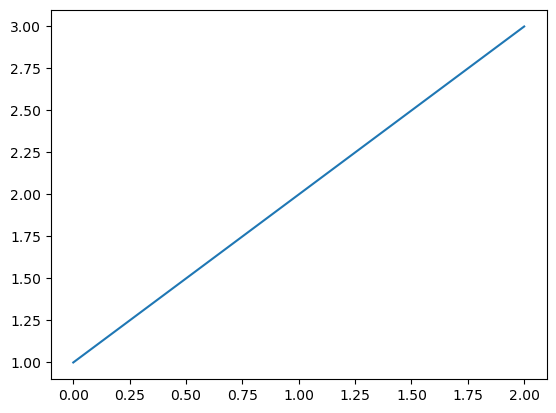

In [56]:
import matplotlib.pyplot as plt
plt.plot([1,2,3])

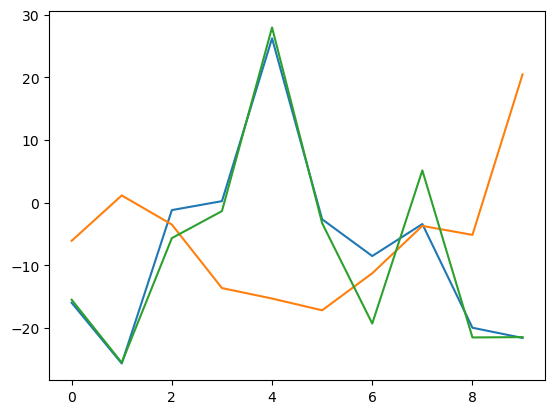

In [57]:
plt.plot(l[10])
plt.plot(l[1])
plt.plot(l[520])

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log

# ---- (선택) 여러분의 "현재 구현" soft-temperature 로직을 여기에 할당할 수 있습니다.
# 예: def CURRENT_SOFT_FN(logits): return torch.softmax(logits / T_cur, dim=1)
CURRENT_SOFT_FN = globals().get("CURRENT_SOFT_FN", None)

# ---- 1) fc forward hook으로 raw logits 캡처
class _Capture:
    def __init__(self):
        self.outputs = None
    def __call__(self, module, inputs, output):
        self.outputs = output.detach()

cap = _Capture()

# teacher의 마지막 선형 레이어(기본: 'fc')에 훅 등록
fc_module = dict(teacher.named_modules()).get("fc", None)
assert fc_module is not None, "teacher에 'fc' 모듈이 없습니다. 마지막 레이어명이 다르면 해당 이름으로 바꿔주세요."
_hook_handle = fc_module.register_forward_hook(cap)

teacher.eval()
device = torch.device(device) if not isinstance(device, torch.device) else device

# 검증용으로 첫 배치
batch = next(iter(val_loader))
x, y = batch[0].to(device), batch[1].to(device)

with torch.no_grad():
    logits_live = teacher(x)       # 모델 최종 출력 (logits)
fc_logits = cap.outputs             # fc 훅으로 캡처된 출력 (logits)

# fc출력과 최종 logits 일치 확인(ResNet 계열이면 동일해야 정상)
max_abs_diff = (fc_logits - logits_live).abs().max().item()
print(f"[Step1] fc출력 vs 최종 logits max|diff| = {max_abs_diff:.6g}")

# 훅 해제(필요시 유지해도 무방)
_hook_handle.remove()

# 샘플 일부 미리 보기
n_show = min(5, x.size(0))
print("\n[Step1] raw logits (first %d samples, first 10 dims)" % n_show)
print(logits_live[:n_show, :10].detach().cpu())


[Step1] fc출력 vs 최종 logits max|diff| = 0

[Step1] raw logits (first 5 samples, first 10 dims)
tensor([[-10.4856,  -7.5395,  -7.9801,  12.1848, -10.5190,   4.0430,  -3.4037,
          -8.5963, -13.3553,  -8.3005],
        [  2.8084,   0.5639, -11.7855,  -8.1076, -12.7037, -14.1369, -14.0405,
         -15.7579,  18.7900,   0.0608],
        [  0.4710,   8.5628, -13.9593, -13.1612,  -5.7144, -13.4750, -15.3270,
         -10.4337,  10.5032,  -0.2670],
        [ 14.6049,  -4.9146,  -3.7491,  -6.1102, -13.6717, -18.3032, -16.3191,
         -14.4122,   1.7668,   3.2805],
        [-12.3778,  -9.6593,  -1.2176,  -2.0637,   6.9250, -10.5054,  17.6865,
         -10.9632, -10.0856, -12.2022]])


In [47]:
with torch.no_grad():
    prob = F.softmax(logits_live, dim=1)
    pred = prob.argmax(1)
    acc = (pred == y).float().mean().item()

print(f"[Step2] batch accuracy = {acc*100:.2f}%")
print("[Step2] pred vs target (first %d):" % n_show)
print(torch.stack([pred[:n_show].detach().cpu(), y[:n_show].detach().cpu()], dim=1))


[Step2] batch accuracy = 87.11%
[Step2] pred vs target (first 5):
tensor([[3, 3],
        [8, 8],
        [8, 8],
        [0, 0],
        [6, 6]])


In [48]:
soft_current = None
if CURRENT_SOFT_FN is not None:
    with torch.no_grad():
        soft_current = CURRENT_SOFT_FN(logits_live.detach())
    print("\n[Step3] CURRENT_SOFT_FN 분포 미리보기 (first %d, first 10 dims)" % n_show)
    print(soft_current[:n_show, :10].cpu())

    # 엔트로피(분포 날카로움)와 top1
    H_cur = -(soft_current.clamp_min(1e-12).log() * soft_current).sum(1).mean().item()
    C = prob.size(1)
    print(f"[Step3] avg entropy (nats) = {H_cur:.3f} (lnC={log(C):.3f})")
    print("[Step3] current(top1) (first %d):" % n_show, soft_current.argmax(1)[:n_show].tolist())
else:
    print("\n[Step3] CURRENT_SOFT_FN이 정의되어 있지 않아 건너뜁니다. "
          "여러분의 현재 로직 함수를 CURRENT_SOFT_FN 변수에 할당하면 이 블록이 동작합니다.")



[Step3] CURRENT_SOFT_FN이 정의되어 있지 않아 건너뜁니다. 여러분의 현재 로직 함수를 CURRENT_SOFT_FN 변수에 할당하면 이 블록이 동작합니다.


In [49]:
def kd_soft_targets(logits, T: float):
    return F.softmax(logits / T, dim=1)

with torch.no_grad():
    soft_kd = kd_soft_targets(logits_live.detach(), T=float(globals().get("T", 1.0)))

print("\n[Step4] KD 수식(softmax(logits/T)) 분포 미리보기 (first %d, first 10 dims)" % n_show)
print(soft_kd[:n_show, :10].cpu())

H_kd = -(soft_kd.clamp_min(1e-12).log() * soft_kd).sum(1).mean().item()
C = prob.size(1)
print(f"[Step4] avg entropy (nats) = {H_kd:.3f} (lnC={log(C):.3f})")
print("[Step4] kd(T)   (top1) (first %d):" % n_show, soft_kd.argmax(1)[:n_show].tolist())



[Step4] KD 수식(softmax(logits/T)) 분포 미리보기 (first 5, first 10 dims)
tensor([[1.4265e-10, 2.7149e-09, 1.7473e-09, 9.9971e-01, 1.3796e-10, 2.9104e-04,
         1.6979e-07, 9.4360e-10, 8.0903e-12, 1.2684e-09],
        [1.1462e-07, 1.2148e-08, 5.2629e-14, 2.0822e-12, 2.1011e-14, 5.0124e-15,
         5.5192e-15, 9.9089e-16, 1.0000e+00, 7.3456e-09],
        [3.8437e-05, 1.2559e-01, 2.0785e-11, 4.6167e-11, 7.9152e-08, 3.3734e-11,
         5.2939e-12, 7.0612e-10, 8.7436e-01, 1.8376e-05],
        [9.9999e-01, 3.3325e-09, 1.0689e-08, 1.0082e-09, 5.2431e-13, 5.1068e-15,
         3.7141e-14, 2.5004e-13, 2.6574e-06, 1.2074e-05],
        [8.7745e-14, 1.3301e-12, 6.1666e-09, 2.6459e-09, 2.1200e-05, 5.7069e-13,
         9.9998e-01, 3.6107e-13, 8.6841e-13, 1.0459e-13]])
[Step4] avg entropy (nats) = 0.084 (lnC=2.303)
[Step4] kd(T)   (top1) (first 5): [3, 8, 8, 0, 6]


In [51]:
import torch

bank_path = "src/model/ckpts/soft_targets/cifar10_fp16.pt"
payload = torch.load(bank_path, map_location="cpu")
l = payload["logits"].to(torch.float32)  # (N,C)

print("shape:", tuple(l.shape))
top1 = l.argmax(1)
print("argmax bincount (first 10 classes):", torch.bincount(top1, minlength=l.shape[1])[:10])
print("sum of top1 indices:", top1.sum().item())

# 엔트로피도 확인
import torch.nn.functional as F, math
p = F.softmax(l, dim=1)
H = -(p.clamp_min(1e-12).log() * p).sum(1).mean().item()
print(f"avg entropy (nats) = {H:.3f} (lnC={math.log(l.shape[1]):.3f})")


shape: (50000, 10)
argmax bincount (first 10 classes): tensor([50000,     0,     0,     0,     0,     0,     0,     0,     0,     0])
sum of top1 indices: 0
avg entropy (nats) = 1.668 (lnC=2.303)


C:\Users\gauoo\AppData\Local\Temp\ipykernel_69556\2966359861.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  payload = torch.load(bank_path, map_location="cpu")
